In [1]:
%load_ext autoreload
%autoreload 2

### 2. Test the Foward part of the Network
> * Now make sure that we can map from an image into an SxSx2x11 Tensor
> * First make sure that the Yolo2 weights are loadable and make sense.

In [2]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'
from Model.vis_utils import visualize_grid

/Users/likhuva/anaconda2/envs/cs231n/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# l2 = np.array(list((yolo_weights['model_weights']['conv2d_1']['conv2d_1'][u'kernel:0'])))
# grid = visualize_grid(l2.transpose(3, 1, 2, 0))
# print (grid.shape, l2.shape)
# plt.imshow(grid.astype('uint8'))
# plt.axis('off')
# plt.gcf().set_size_inches(5, 5)
# plt.show()

#### 2.1 Overfit Localizer in Tiny Data
> * For debugging, we run the foward, and backward pass for `a few`
epochs.

In [4]:
import torch
print(torch.__version__)
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from Model.dataloader import NutritionDataset
from Model.net import LocalizerNet
from train import train_localizer

0.4.0


In [96]:
def train_localizer_network():
    IMAGE_DIR = '../Data/FullData/RawImages/'
    BOXES = '../Data/FullData/BoundingBoxes.npy'
    DATA_PATH = '../Data/FullData/train_dev_test.npy'
    YOLO_PATH = '../Data/FullData/yolo.h5'
    
    dataset = DataLoader(
        NutritionDataset(IMAGE_DIR, BOXES, DATA_PATH),
        batch_size=32, shuffle=True, num_workers=4
    )
    model = LocalizerNet(YOLO_PATH)
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=1e-3
    )
    r = train_localizer(model, optimizer, dataset)
    return r    

In [97]:
losses, final_y_hat, y = train_localizer_network()

Loss =  0.08131743222475052
Loss =  1.7777891159057617
Loss =  0.3449292480945587
Loss =  0.14830617606639862
Loss =  0.04740329086780548
Loss =  0.018149957060813904
Loss =  0.006753518711775541
Loss =  0.002637561410665512
Loss =  0.0009655581670813262
Loss =  0.00036417500814422965


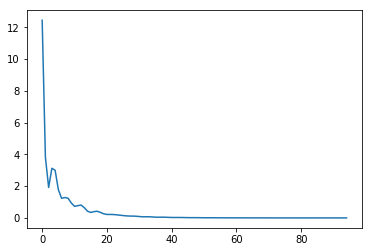

In [100]:
plt.plot(np.array(losses)[5:])

In [102]:
y_hat = final_y_hat.reshape(5, 5, 5, 2, 11)
y = y.reshape(y_hat.shape)

In [105]:
print (y_hat[y_hat[:, :, :, :, 0] > 0.8][0])
print(y[y_hat[:, :, :, :, 0] > 0.8][0])

tensor([ 1.0114,  0.8206,  0.3159,  0.1172,  0.2023,  0.1002,  0.4271,
         0.7192,  0.5153,  1.0186, -0.0180])
tensor([ 1.0000,  0.8148,  0.2937,  0.1361,  0.2224,  0.0815,  0.4401,
         0.7102,  0.4875,  1.0000,  0.0000])
